# Gallstone Prediction

- DataSet: `gallstone.csv`


In [1]:
# Import package
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import scipy.sparse as sp


from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    accuracy_score, average_precision_score, brier_score_loss,
    confusion_matrix, f1_score, precision_score, recall_score,
    precision_recall_curve, roc_auc_score, roc_curve
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.calibration import calibration_curve
from sklearn.feature_selection import mutual_info_classif
from sklearn import set_config
set_config(transform_output="pandas")
from sklearn.decomposition import TruncatedSVD


from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.feature_selection import RFECV
from sklearn.calibration import CalibratedClassifierCV

In [2]:
RANDOM_STATE = 16        # random seed
TARGET_COL = 'Gallstone Status'  # label column
DATA_PATH = 'gallstone.csv'      # input file
N_SPLITS = 5             # stratified folds
DO_TUNE = True           # nested CV tuning
N_BOOT = 300             # bootstrap rounds
TOP_N_FEATURES = 15      # print top features

In [3]:
df = pd.read_csv(DATA_PATH)
if TARGET_COL not in df.columns:
    raise ValueError(f'missing target: {TARGET_COL}')

# split features / target
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int)

# basic data checks
print('Data shape:', df.shape)
print('Missing values:', df.isna().sum().sum())
print('Duplicate rows:', df.duplicated().sum())
print('Target distribution:')
print(y.value_counts())
print('Positive rate:', y.mean())

Data shape: (319, 39)
Missing values: 0
Duplicate rows: 0
Target distribution:
Gallstone Status
0    161
1    158
Name: count, dtype: int64
Positive rate: 0.4952978056426332


# Feature Engineering

In [4]:
# Feature engineering
new_feats = []
eps = 1e-6

def add_ratio(numer, denom, name):
    if numer in df.columns and denom in df.columns:
        df[name] = df[numer] / (df[denom] + eps)
        new_feats.append(name)

if 'Low Density Lipoprotein (LDL)' in df.columns and 'High Density Lipoprotein (HDL)' in df.columns:
    add_ratio('Low Density Lipoprotein (LDL)', 'High Density Lipoprotein (HDL)', 'LDL_to_HDL')
if 'Total Cholesterol (TC)' in df.columns and 'High Density Lipoprotein (HDL)' in df.columns:
    add_ratio('Total Cholesterol (TC)', 'High Density Lipoprotein (HDL)', 'TC_to_HDL')
if 'Triglyceride' in df.columns and 'High Density Lipoprotein (HDL)' in df.columns:
    add_ratio('Triglyceride', 'High Density Lipoprotein (HDL)', 'TG_to_HDL')
if 'Aspartat Aminotransferaz (AST)' in df.columns and 'Alanin Aminotransferaz (ALT)' in df.columns:
    add_ratio('Aspartat Aminotransferaz (AST)', 'Alanin Aminotransferaz (ALT)', 'AST_to_ALT')
if 'Age' in df.columns and 'Body Mass Index (BMI)' in df.columns:
    df['Age_x_BMI'] = df['Age'] * df['Body Mass Index (BMI)']
    new_feats.append('Age_x_BMI')

# refresh X, y after feature engineering
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int)

print('New features added:', new_feats)


New features added: ['LDL_to_HDL', 'TC_to_HDL', 'TG_to_HDL', 'AST_to_ALT', 'Age_x_BMI']


In [5]:
# column groups
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

binary_cols = [
    c for c in X.columns
    if set(X[c].dropna().unique()).issubset({0, 1}) and X[c].dropna().nunique() > 0
]

continuous_cols = [c for c in X.columns if c not in binary_cols and c not in cat_cols]
num_cols = [c for c in X.columns if c not in cat_cols]

print("Categorical cols:", cat_cols)
print("Binary cols (0/1):", binary_cols)
print("Continuous cols:", len(continuous_cols))

Categorical cols: []
Binary cols (0/1): ['Gender', 'Coronary Artery Disease (CAD)', 'Hypothyroidism', 'Hyperlipidemia', 'Diabetes Mellitus (DM)']
Continuous cols: 38


In [6]:
# VIF for multicollinearity (continuous features only)
vif_cols = [c for c in continuous_cols if c in X.columns]
vif_data = X[vif_cols].copy()
vif_data = vif_data.fillna(vif_data.median())

vif_rows = []
for i, col in enumerate(vif_cols):
    try:
        v = variance_inflation_factor(vif_data.values, i)
    except Exception:
        v = np.nan
    vif_rows.append({'feature': col, 'vif': v})

vif_df = pd.DataFrame(vif_rows).sort_values(by='vif', ascending=False)
print('Top VIF features:')
print(vif_df.head(15))

high_vif = vif_df[vif_df['vif'] > 10]['feature'].tolist()
print('High VIF (>10):', high_vif)

USE_VIF_FILTER = False
if USE_VIF_FILTER and high_vif:
    X = X.drop(columns=high_vif)
    print('Dropped high VIF features:', high_vif)


Top VIF features:
                                           feature          vif
2                                           Height  7014.424364
3                                           Weight  5534.324867
10                              Lean Mass (LM) (%)  3491.672279
8   Extracellular Fluid/Total Body Water (ECF/TBW)  3008.743706
6                        Extracellular Water (ECW)  2912.869893
4                            Body Mass Index (BMI)  2434.339195
21                          Total Cholesterol (TC)  1816.421014
34                                       TC_to_HDL  1409.068826
22                   Low Density Lipoprotein (LDL)  1206.142502
33                                      LDL_to_HDL  1019.920229
5                           Total Body Water (TBW)   880.876886
9                  Total Body Fat Ratio (TBFR) (%)   667.047548
37                                       Age_x_BMI   587.629789
0                                              Age   547.677394
14                    

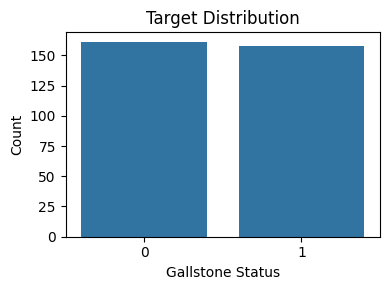

In [7]:
# EDA
# 1) Target distribution
plt.figure(figsize=(4, 3))
sns.countplot(x=y)
plt.title("Target Distribution")
plt.xlabel("Gallstone Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

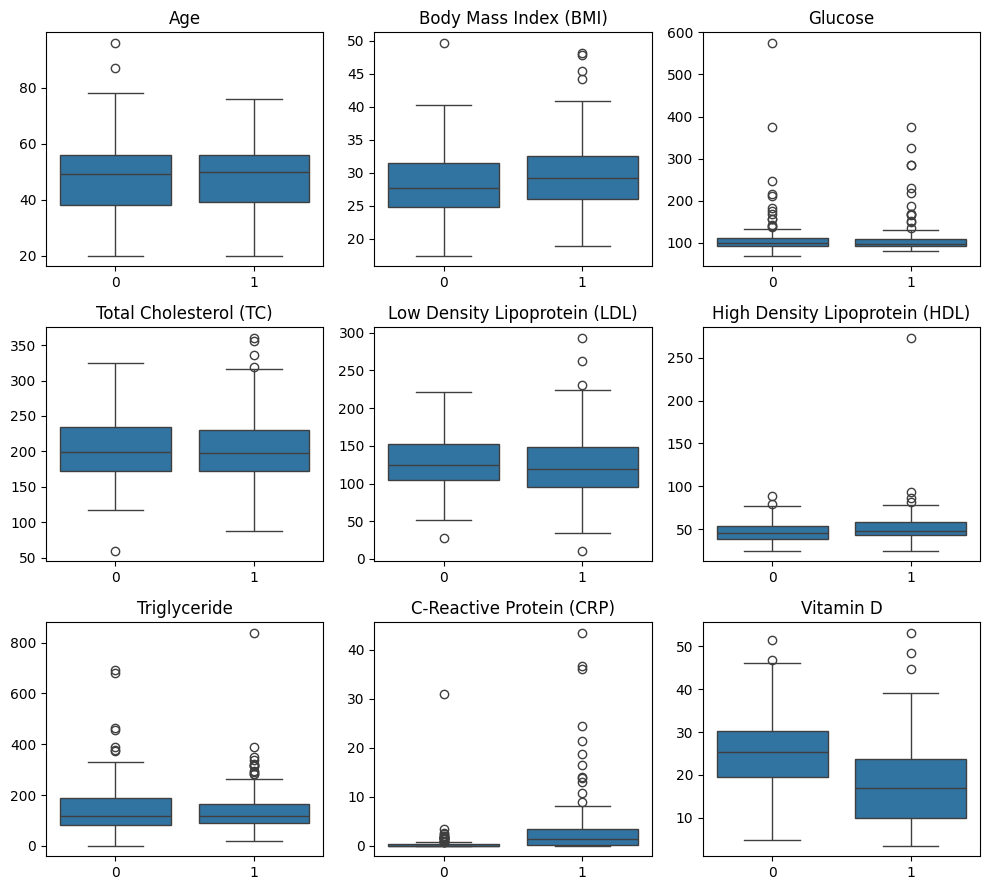

In [8]:
# 2) Key continuous features vs target (boxplots, 3x3 grid)
key_feats = [
    "Age",
    "Body Mass Index (BMI)",
    "Glucose",
    "Total Cholesterol (TC)",
    "Low Density Lipoprotein (LDL)",
    "High Density Lipoprotein (HDL)",
    "Triglyceride",
    "C-Reactive Protein (CRP)",
    "Vitamin D",
]

fig, axes = plt.subplots(3, 3, figsize=(10, 9))
axes = axes.flatten()

for i, f in enumerate(key_feats):
    ax = axes[i]
    if f in df.columns:
        sns.boxplot(x=y, y=df[f], ax=ax)
        ax.set_title(f)
        ax.set_xlabel("")
        ax.set_ylabel("")
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()

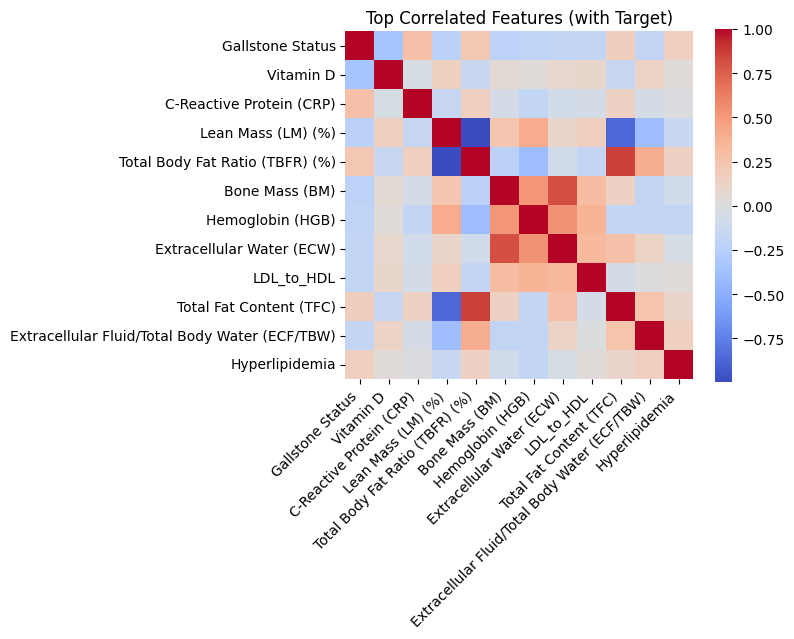

In [9]:
# 3) Top correlated features heatmap
corr = pd.concat([X, y], axis=1).corr()
top_feats = corr[TARGET_COL].abs().sort_values(ascending=False).head(12).index  # smaller for clarity

plt.figure(figsize=(8, 7))
sns.heatmap(
    corr.loc[top_feats, top_feats],
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Top Correlated Features (with Target)")
plt.tight_layout()
plt.show()

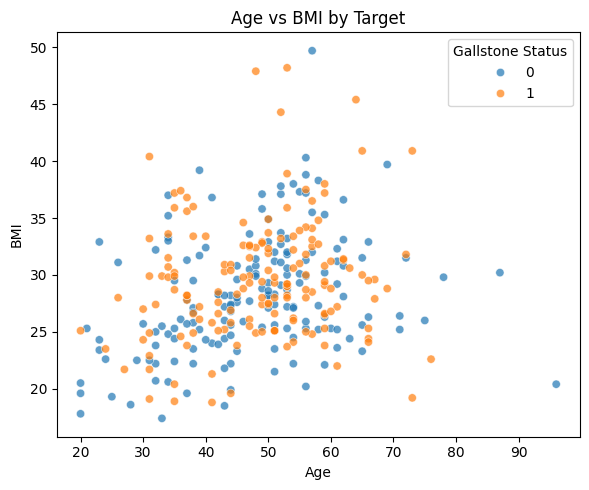

In [10]:
# 4) Age vs BMI scatter by target
if "Age" in df.columns and "Body Mass Index (BMI)" in df.columns:
    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        x=df["Age"],
        y=df["Body Mass Index (BMI)"],
        hue=y,
        alpha=0.7
    )
    plt.title("Age vs BMI by Target")
    plt.xlabel("Age")
    plt.ylabel("BMI")
    plt.tight_layout()
    plt.show()

In [11]:
corr = pd.concat([X, y], axis=1).corr()[TARGET_COL].drop(TARGET_COL)
print('Top correlations:')
print(corr.sort_values(ascending=False).head(10))
print('Bottom correlations:')
print(corr.sort_values(ascending=True).head(10))

Top correlations:
C-Reactive Protein (CRP)           0.281995
Total Body Fat Ratio (TBFR) (%)    0.225470
Total Fat Content (TFC)            0.170158
Hyperlipidemia                     0.161901
High Density Lipoprotein (HDL)     0.158622
Gender                             0.153483
Visceral Fat Area (VFA)            0.140397
Body Mass Index (BMI)              0.121507
Alkaline Phosphatase (ALP)         0.109882
Diabetes Mellitus (DM)             0.104689
Name: Gallstone Status, dtype: float64
Bottom correlations:
Vitamin D                                        -0.354873
Lean Mass (LM) (%)                               -0.225749
Bone Mass (BM)                                   -0.216570
Hemoglobin (HGB)                                 -0.196872
Extracellular Water (ECW)                        -0.178436
LDL_to_HDL                                       -0.177053
Extracellular Fluid/Total Body Water (ECF/TBW)   -0.169826
TC_to_HDL                                        -0.145906
Aspartat A

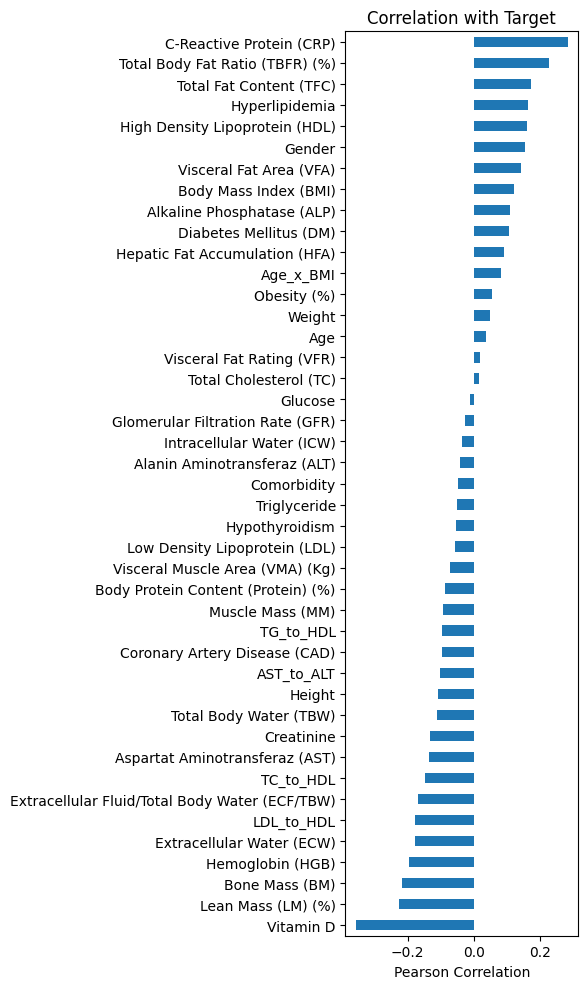

In [12]:
corr_sorted = corr.sort_values()
plt.figure(figsize=(6, 10))
corr_sorted.plot(kind='barh')
plt.title('Correlation with Target')
plt.xlabel('Pearson Correlation')
plt.tight_layout()
plt.show()

In [13]:
# Helper functions for modeling
def make_preprocessor(scale_numeric: bool):
    # numeric: median impute + optional scaling
    num_steps = [('imputer', SimpleImputer(strategy='median'))]
    if scale_numeric:
        num_steps.append(('scaler', StandardScaler()))
    transformers = []
    if num_cols:
        transformers.append(('num', Pipeline(steps=num_steps), num_cols))
    if cat_cols:
        transformers.append(('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent'))]), cat_cols))
    return ColumnTransformer(transformers=transformers, remainder='drop')

def build_models():
    # linear needs scaling; trees do not
    pre_linear = make_preprocessor(scale_numeric=True)
    pre_tree = make_preprocessor(scale_numeric=False)
    return {
        'log_reg': Pipeline([
            ('pre', pre_linear),
            ('clf', LogisticRegression(max_iter=2000, solver='liblinear', random_state=RANDOM_STATE))
        ]),
        'random_forest': Pipeline([
            ('pre', pre_tree),
            ('clf', RandomForestClassifier(n_estimators=400, max_features='sqrt', random_state=RANDOM_STATE))
        ]),
        'hist_gb': Pipeline([
            ('pre', pre_tree),
            ('clf', HistGradientBoostingClassifier(learning_rate=0.1, max_iter=200, random_state=RANDOM_STATE))
        ]),
        'lightgbm': Pipeline([
            ('pre', pre_tree),
            ('clf', LGBMClassifier(n_estimators=300, learning_rate=0.05, num_leaves=31, random_state=RANDOM_STATE, verbose=-1, force_row_wise=True))
        ]),
        'xgboost': Pipeline([
            ('pre', pre_tree),
            ('clf', XGBClassifier(
                n_estimators=300, learning_rate=0.05, max_depth=4,
                subsample=0.8, colsample_bytree=0.8,
                random_state=RANDOM_STATE, eval_metric='logloss'
            ))
        ])
    }

def build_param_grids():
    # small grid for nested CV
    return {
        'log_reg': {'clf__C': [0.1, 1.0, 10.0], 'clf__penalty': ['l2']},
        'random_forest': {
            'clf__n_estimators': [300, 600],
            'clf__max_depth': [None, 5, 10],
            'clf__min_samples_leaf': [1, 3],
            'clf__max_features': ['sqrt', 0.5]
        },
        'hist_gb': {
            'clf__learning_rate': [0.05, 0.1],
            'clf__max_depth': [None, 3],
            'clf__max_iter': [150, 250],
            'clf__l2_regularization': [0.0, 0.1]
        },
        'lightgbm': {
            'clf__n_estimators': [200, 400],
            'clf__learning_rate': [0.05, 0.1],
            'clf__num_leaves': [15, 31, 63]
        },
        'xgboost': {
            'clf__n_estimators': [200, 400],
            'clf__learning_rate': [0.05, 0.1],
            'clf__max_depth': [3, 5],
            'clf__subsample': [0.8, 1.0],
            'clf__colsample_bytree': [0.8, 1.0]
        }
    }

def oof_predict_proba(estimator, X, y, cv):
    proba = cross_val_predict(estimator, X, y, cv=cv, method='predict_proba', n_jobs=-1)
    return proba[:, 1]

def best_f1_threshold(y_true, y_prob):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    f1 = 2 * precision * recall / (precision + recall + 1e-12)
    if thresholds.size == 0:
        return 0.5
    idx = int(np.nanargmax(f1))
    return float(thresholds[idx]) if idx < thresholds.size else 0.5

def compute_metrics(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    return {
        'roc_auc': float(roc_auc_score(y_true, y_prob)),
        'pr_auc': float(average_precision_score(y_true, y_prob)),
        'brier': float(brier_score_loss(y_true, y_prob)),
        'accuracy': float(accuracy_score(y_true, y_pred)),
        'precision': float(precision_score(y_true, y_pred, zero_division=0)),
        'recall': float(recall_score(y_true, y_pred, zero_division=0)),
        'f1': float(f1_score(y_true, y_pred, zero_division=0))
    }

def bootstrap_ci(y_true, y_prob, threshold, n_boot=300, seed=42):
    rng = np.random.default_rng(seed)
    rows = []
    for _ in range(n_boot):
        idx = rng.integers(0, len(y_true), len(y_true))
        yt = y_true[idx]
        yp = y_prob[idx]
        try:
            rows.append(compute_metrics(yt, yp, threshold))
        except Exception:
            continue
    if not rows:
        return {}
    dfm = pd.DataFrame(rows)
    out = {}
    for col in dfm.columns:
        out[col] = {
            'mean': float(dfm[col].mean()),
            'p025': float(dfm[col].quantile(0.025)),
            'p975': float(dfm[col].quantile(0.975)),
        }
    return out

def subgroup_report(df, y_true, y_prob, threshold, col, max_groups=6):
    if col not in df.columns:
        return
    vals = df[col].dropna()
    if vals.nunique() > max_groups:
        return
    print('\nSubgroup:', col)
    for v in sorted(vals.unique()):
        mask = df[col] == v
        if mask.sum() < 10:
            continue
        m = compute_metrics(y_true[mask], y_prob[mask], threshold)
        line = '  {}: n={} AUC={:.3f} F1={:.3f} R={:.3f}'.format(
            v, mask.sum(), m['roc_auc'], m['f1'], m['recall']
        )
        print(line)

In [14]:
# Feature selection (MI + L1 + RFECV), compare and choose
np.random.seed(RANDOM_STATE)
X_base = X.copy()

# MI
discrete_mask = [
    set(X_base[c].dropna().unique()).issubset({0, 1}) and X_base[c].dropna().nunique() > 0
    for c in X_base.columns
]
X_imputed = X_base.fillna(X_base.median())
mi = mutual_info_classif(X_imputed, y, discrete_features=discrete_mask, random_state=RANDOM_STATE)
mi_df = pd.DataFrame({'feature': X_base.columns, 'mi': mi}).sort_values('mi', ascending=False)
print('Top MI features:')
print(mi_df.head(15))

# L1
lasso_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty='l1', solver='saga', max_iter=5000, random_state=RANDOM_STATE))
])
lasso_pipe.fit(X_base, y)
coef = lasso_pipe.named_steps['clf'].coef_.ravel()
lasso_df = pd.DataFrame({'feature': X_base.columns, 'coef': coef}).sort_values('coef', key=np.abs, ascending=False)
selected_lasso = lasso_df[lasso_df['coef'] != 0]['feature'].tolist()
print('L1 selected features:')
print(selected_lasso)

# RFECV
rfecv_cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
X_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
]).fit_transform(X_base)

rfecv = RFECV(
    estimator=LogisticRegression(max_iter=2000, solver='liblinear', random_state=RANDOM_STATE),
    step=1,
    cv=rfecv_cv,
    scoring='roc_auc',
    n_jobs=-1
)
rfecv.fit(X_rf, y)
rfecv_features = X_base.columns[rfecv.support_].tolist()
print('RFECV selected features:', rfecv_features)
print('RFECV selected count:', len(rfecv_features))

# CV choose best MI k
k_list = [5, 8, 10, 12, 15, 20, 25]
k_list = [k for k in k_list if k <= X_base.shape[1]]
fs_cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

mi_k_rows = []
for k in k_list:
    feats = mi_df.head(k)['feature'].tolist()
    X_sub = X_base[feats]
    pre = ColumnTransformer([
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), feats)
    ], remainder='drop')
    model = Pipeline([('pre', pre), ('clf', LogisticRegression(max_iter=2000, solver='liblinear', random_state=RANDOM_STATE))])
    y_prob = oof_predict_proba(model, X_sub, y, fs_cv)
    thr = best_f1_threshold(y.values, y_prob)
    metrics = compute_metrics(y.values, y_prob, thr)
    mi_k_rows.append({'k': k, 'roc_auc': metrics['roc_auc'], 'pr_auc': metrics['pr_auc'], 'f1': metrics['f1']})

mi_k_df = pd.DataFrame(mi_k_rows).sort_values('roc_auc', ascending=False)
best_k = int(mi_k_df.iloc[0]['k'])
print('MI k selection:')
print(mi_k_df.to_string(index=False, float_format=lambda x: f'{x:.3f}'))
print('Best k:', best_k)

feature_sets = {
    'mi_topk': mi_df.head(best_k)['feature'].tolist(),
    'lasso': selected_lasso,
    'rfecv': rfecv_features
}

# Compare methods (same model + same CV)
fs_rows = []
for name, feats in feature_sets.items():
    if len(feats) == 0:
        continue
    X_sub = X_base[feats]
    pre = ColumnTransformer([
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), feats)
    ], remainder='drop')
    model = Pipeline([('pre', pre), ('clf', LogisticRegression(max_iter=2000, solver='liblinear', random_state=RANDOM_STATE))])
    y_prob = oof_predict_proba(model, X_sub, y, fs_cv)
    thr = best_f1_threshold(y.values, y_prob)
    metrics = compute_metrics(y.values, y_prob, thr)
    fs_rows.append({
        'method': name,
        'n_features': len(feats),
        'roc_auc': metrics['roc_auc'],
        'pr_auc': metrics['pr_auc'],
        'f1': metrics['f1']
    })

fs_df = pd.DataFrame(fs_rows).sort_values('roc_auc', ascending=False)
print('Feature selection comparison:')
print(fs_df.to_string(index=False, float_format=lambda x: f'{x:.3f}'))

# choose best by metric
SELECT_METRIC = 'roc_auc'  # change to 'pr_auc' or 'f1' if needed
best_method = fs_df.sort_values(SELECT_METRIC, ascending=False).iloc[0]['method']
print('Selected feature set:', best_method)

selected_features = feature_sets.get(best_method, feature_sets['mi_topk'])
X = X_base[selected_features]

# re-define column groups after selection
cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
binary_cols = [
    c for c in X.columns
    if set(X[c].dropna().unique()).issubset({0, 1}) and X[c].dropna().nunique() > 0
]
continuous_cols = [c for c in X.columns if c not in binary_cols and c not in cat_cols]
num_cols = [c for c in X.columns if c not in cat_cols]
print('Final feature count:', X.shape[1])

Top MI features:
                                           feature        mi
35                        C-Reactive Protein (CRP)  0.215989
11                       Extracellular Water (ECW)  0.118897
13  Extracellular Fluid/Total Body Water (ECF/TBW)  0.100830
24                  Hepatic Fat Accumulation (HFA)  0.094832
12                       Intracellular Water (ICW)  0.091492
42                                       Age_x_BMI  0.075549
41                                      AST_to_ALT  0.074221
37                                       Vitamin D  0.071824
18                                  Bone Mass (BM)  0.055506
26                          Total Cholesterol (TC)  0.046774
32                      Alkaline Phosphatase (ALP)  0.040068
16              Body Protein Content (Protein) (%)  0.036013
36                                Hemoglobin (HGB)  0.035518
33                                      Creatinine  0.031126
29                                    Triglyceride  0.024755
L1 sele

## Baseline models (OOF)

In [15]:
# Baseline OOF
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
models = build_models()

results = []
for name, model in models.items():
    y_prob = oof_predict_proba(model, X, y, cv)
    thr = best_f1_threshold(y.values, y_prob)
    metrics = compute_metrics(y.values, y_prob, thr)
    if name == "xgboost":
        xgb_oof_prob = y_prob.copy()
        xgb_best_thr = thr
    metrics.update({"model": name, "best_threshold": thr})
    results.append(metrics)
    print("- {}: AUC={:.3f} PR-AUC={:.3f} F1={:.3f} Thr={:.3f}".format(
        name, metrics["roc_auc"], metrics["pr_auc"], metrics["f1"], thr
    ))

baseline_df = pd.DataFrame(results).sort_values(by="pr_auc", ascending=False)
best_model_name = baseline_df.iloc[0]["model"]
print("\nBest baseline model:", best_model_name)
print(baseline_df)

- log_reg: AUC=0.869 PR-AUC=0.864 F1=0.818 Thr=0.397
- random_forest: AUC=0.853 PR-AUC=0.868 F1=0.794 Thr=0.465
- hist_gb: AUC=0.845 PR-AUC=0.875 F1=0.769 Thr=0.403
- lightgbm: AUC=0.839 PR-AUC=0.867 F1=0.768 Thr=0.561
- xgboost: AUC=0.858 PR-AUC=0.884 F1=0.792 Thr=0.597

Best baseline model: xgboost
    roc_auc    pr_auc     brier  accuracy  precision    recall        f1  \
4  0.857850  0.884452  0.158427  0.802508   0.827586  0.759494  0.792079   
2  0.844524  0.875059  0.187725  0.768025   0.759259  0.778481  0.768750   
1  0.852524  0.867787  0.164279  0.789969   0.772455  0.816456  0.793846   
3  0.838784  0.866938  0.186932  0.771160   0.770701  0.765823  0.768254   
0  0.869133  0.863884  0.142781  0.815047   0.796407  0.841772  0.818462   

           model  best_threshold  
4        xgboost        0.596830  
2        hist_gb        0.403335  
1  random_forest        0.465000  
3       lightgbm        0.560816  
0        log_reg        0.397025  


## Nested CV tuning

In [16]:
if DO_TUNE:
    grids = build_param_grids()
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    grid = GridSearchCV(
        models[best_model_name],
        grids[best_model_name],
        scoring='roc_auc',
        cv=inner_cv,
        n_jobs=-1
    )
    oof_prob = oof_predict_proba(grid, X, y, cv)
    best_thr = best_f1_threshold(y.values, oof_prob)
    tuned_metrics = compute_metrics(y.values, oof_prob, best_thr)
    print('Tuned OOF metrics:', tuned_metrics)
    print('Best threshold:', best_thr)

    # Resource allocation

    y_true = y.values

    def policy_summary(y_true, y_hat, fn_cost=5.0, fp_cost=1.0):
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        precision = tp / (tp + fp) if (tp + fp) else 0.0
        recall    = tp / (tp + fn) if (tp + fn) else 0.0
        f1        = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0
        total_cost = fn_cost * fn + fp_cost * fp
        screened = tp + fp
        return {
            "screened": screened, "TP": tp, "FP": fp, "FN": fn, "TN": tn,
            "precision": precision, "recall": recall, "f1": f1, "cost": total_cost
        }

    def best_cost_threshold(y_true, prob, fn_cost=5.0, fp_cost=1.0):
        thrs = np.unique(prob)
        best_t, best_cost = None, float("inf")
        for t in thrs:
            y_hat = (prob >= t).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
            cost = fn_cost * fn + fp_cost * fp
            if cost < best_cost:
                best_t, best_cost = t, cost
        return best_t, best_cost

    # Policy 1: Top-K (resource-limited)
    rows = []
    for k in [10, 20, 30, 50]:
        k = min(k, len(oof_prob))
        idx = np.argsort(-oof_prob)[:k]
        y_hat = np.zeros_like(y_true)
        y_hat[idx] = 1
        s = policy_summary(y_true, y_hat, fn_cost=5, fp_cost=1)
        rows.append({"policy": f"Top-{k}", **s})
        print(f"[Top-{k}] screened={s['screened']} TP={s['TP']} FP={s['FP']} FN={s['FN']} "
            f"prec={s['precision']:.3f} rec={s['recall']:.3f} cost={s['cost']:.1f}")

    # Policy 2: F1-opt threshold
    y_hat_f1 = (oof_prob >= best_thr).astype(int)
    s_f1 = policy_summary(y_true, y_hat_f1, fn_cost=5, fp_cost=1)
    rows.append({"policy": "F1-opt", **s_f1})
    print(f"[F1-opt] screened={s_f1['screened']} TP={s_f1['TP']} FP={s_f1['FP']} FN={s_f1['FN']} "
        f"prec={s_f1['precision']:.3f} rec={s_f1['recall']:.3f} cost={s_f1['cost']:.1f}")

    # Policy 3: Cost-sensitive threshold (FN >> FP)
    t_cost, cost_val = best_cost_threshold(y_true, oof_prob, fn_cost=5.0, fp_cost=1.0)
    y_hat_cost = (oof_prob >= t_cost).astype(int)
    s_cost = policy_summary(y_true, y_hat_cost, fn_cost=5, fp_cost=1)
    rows.append({"policy": "Cost-sensitive", **s_cost})
    print(f"[Cost-sensitive] best_thr={t_cost:.3f} screened={s_cost['screened']} TP={s_cost['TP']} "
        f"FP={s_cost['FP']} FN={s_cost['FN']} prec={s_cost['precision']:.3f} "
        f"rec={s_cost['recall']:.3f} cost={s_cost['cost']:.1f}")

    # Comparison Table
    policy_df = pd.DataFrame(rows)[
        ["policy", "screened", "TP", "FP", "FN", "precision", "recall", "f1", "cost"]
    ].sort_values("cost")
    print("\nPolicy leaderboard (sorted by cost):")
    print(policy_df.to_string(index=False, float_format=lambda x: f"{x:.3f}"))


    grid.fit(X, y)
    final_model = grid.best_estimator_
    print('Best params:', grid.best_params_)
    
else:
    final_model = models[best_model_name].fit(X, y)
    oof_prob = oof_predict_proba(final_model, X, y, cv)
    best_thr = best_f1_threshold(y.values, oof_prob)

Tuned OOF metrics: {'roc_auc': 0.8532117304819562, 'pr_auc': 0.8768667150803993, 'brier': 0.1619990009448129, 'accuracy': 0.8087774294670846, 'precision': 0.8540145985401459, 'recall': 0.740506329113924, 'f1': 0.7932203389830509}
Best threshold: 0.6810770034790039
[Top-10] screened=10 TP=10 FP=0 FN=148 prec=1.000 rec=0.063 cost=740.0
[Top-20] screened=20 TP=20 FP=0 FN=138 prec=1.000 rec=0.127 cost=690.0
[Top-30] screened=30 TP=30 FP=0 FN=128 prec=1.000 rec=0.190 cost=640.0
[Top-50] screened=50 TP=48 FP=2 FN=110 prec=0.960 rec=0.304 cost=552.0
[F1-opt] screened=137 TP=117 FP=20 FN=41 prec=0.854 rec=0.741 cost=225.0
[Cost-sensitive] best_thr=0.054 screened=246 TP=149 FP=97 FN=9 prec=0.606 rec=0.943 cost=142.0

Policy leaderboard (sorted by cost):
        policy  screened  TP  FP  FN  precision  recall    f1  cost
Cost-sensitive       246 149  97   9      0.606   0.943 0.738   142
        F1-opt       137 117  20  41      0.854   0.741 0.793   225
        Top-50        50  48   2 110     

## OOF diagnostics

In [17]:
# Calibration method comparison
cal_base = build_models()[best_model_name]

for method in ['sigmoid', 'isotonic']:
    cal = CalibratedClassifierCV(cal_base, method=method, cv=3)
    cal_prob = oof_predict_proba(cal, X, y, cv)
    thr = best_f1_threshold(y.values, cal_prob)
    metrics = compute_metrics(y.values, cal_prob, thr)
    print(f'Calibrated ({method}) metrics:', metrics)

Calibrated (sigmoid) metrics: {'roc_auc': 0.8542338234137903, 'pr_auc': 0.8799944573236955, 'brier': 0.15958647214105706, 'accuracy': 0.780564263322884, 'precision': 0.775, 'recall': 0.7848101265822784, 'f1': 0.779874213836478}
Calibrated (isotonic) metrics: {'roc_auc': 0.84472049689441, 'pr_auc': 0.8726368345834894, 'brier': 0.15756242855018932, 'accuracy': 0.7774294670846394, 'precision': 0.7735849056603774, 'recall': 0.7784810126582279, 'f1': 0.7760252365930599}


In [18]:
oof_pred = (oof_prob >= best_thr).astype(int)
print('Confusion matrix (OOF):')
print(confusion_matrix(y.values, oof_pred))
print('Metrics (OOF):')
print(compute_metrics(y.values, oof_prob, best_thr))

Confusion matrix (OOF):
[[141  20]
 [ 41 117]]
Metrics (OOF):
{'roc_auc': 0.8532117304819562, 'pr_auc': 0.8768667150803993, 'brier': 0.1619990009448129, 'accuracy': 0.8087774294670846, 'precision': 0.8540145985401459, 'recall': 0.740506329113924, 'f1': 0.7932203389830509}


## Calibration

In [19]:
prob_true, prob_pred = calibration_curve(y.values, oof_prob, n_bins=10, strategy='quantile')
print('Calibration bins (pred_mean -> true_rate):')
for p_pred, p_true in zip(prob_pred, prob_true):
    print('{:.3f} -> {:.3f}'.format(p_pred, p_true))

Calibration bins (pred_mean -> true_rate):
0.005 -> 0.156
0.024 -> 0.125
0.066 -> 0.250
0.170 -> 0.219
0.347 -> 0.344
0.608 -> 0.387
0.823 -> 0.688
0.931 -> 0.875
0.978 -> 0.906
0.996 -> 1.000


## Bootstrap confidence intervals

In [20]:
ci = bootstrap_ci(y.values, oof_prob, best_thr, n_boot=N_BOOT, seed=RANDOM_STATE)
print('Bootstrap CI (mean, 2.5%, 97.5%):')
for k, v in ci.items():
    print('{}: mean={:.3f} [{:.3f}, {:.3f}]'.format(k, v['mean'], v['p025'], v['p975']))


Bootstrap CI (mean, 2.5%, 97.5%):
roc_auc: mean=0.854 [0.807, 0.892]
pr_auc: mean=0.878 [0.830, 0.914]
brier: mean=0.161 [0.133, 0.197]
accuracy: mean=0.809 [0.759, 0.850]
precision: mean=0.853 [0.791, 0.909]
recall: mean=0.743 [0.657, 0.805]
f1: mean=0.794 [0.738, 0.836]


## Subgroup performance

In [21]:
if 'Gender' in df.columns:
    subgroup_report(df, y.values, oof_prob, best_thr, 'Gender')
if 'Age' in df.columns:
    bins = [0, 40, 50, 60, 200]
    labels = ['<=40','41-50','51-60','>60']
    df['Age_bin'] = pd.cut(df['Age'], bins=bins, labels=labels)
    subgroup_report(df, y.values, oof_prob, best_thr, 'Age_bin')



Subgroup: Gender
  0: n=162 AUC=0.853 F1=0.773 R=0.676
  1: n=157 AUC=0.838 F1=0.807 R=0.789

Subgroup: Age_bin
  41-50: n=87 AUC=0.814 F1=0.744 R=0.727
  51-60: n=102 AUC=0.858 F1=0.800 R=0.741
  <=40: n=88 AUC=0.856 F1=0.822 R=0.732
  >60: n=42 AUC=0.915 F1=0.833 R=0.789


## Permutation importance (final model)

In [22]:
perm = permutation_importance(final_model, X, y, n_repeats=20, random_state=RANDOM_STATE, scoring='roc_auc', n_jobs=-1)
fi = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': perm.importances_mean,
    'importance_std': perm.importances_std
}).sort_values(by='importance_mean', ascending=False)
print(fi.head(TOP_N_FEATURES))

                                           feature  importance_mean  \
26                        C-Reactive Protein (CRP)         0.054983   
28                                       Vitamin D         0.003805   
12  Extracellular Fluid/Total Body Water (ECF/TBW)         0.001661   
24                  Aspartat Aminotransferaz (AST)         0.000197   
15              Body Protein Content (Protein) (%)         0.000165   
17                                  Bone Mass (BM)         0.000022   
27                                Hemoglobin (HGB)         0.000020   
20                         Visceral Fat Area (VFA)         0.000002   
21                  Hepatic Fat Accumulation (HFA)         0.000000   
19                         Total Fat Content (TFC)         0.000000   
0                                              Age         0.000000   
22                  High Density Lipoprotein (HDL)         0.000000   
23                                    Triglyceride         0.000000   
25    

/var/folders/s5/prr3_wfs3w5_s6w_9rfsk13m0000gn/T/ipykernel_81743/3279776135.py:31: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_trans_df, feature_names=feature_names_clean)


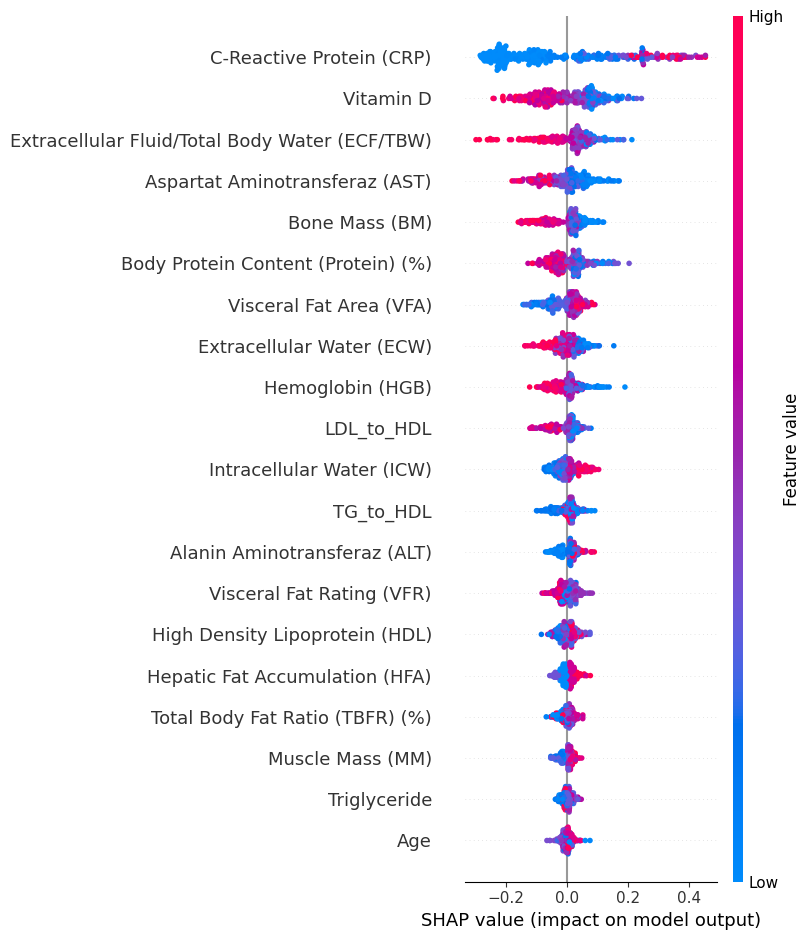

In [23]:
# Pipeline
pre = final_model.named_steps["pre"]
clf = final_model.named_steps["clf"]

# Transform
X_trans = pre.transform(X)
feature_names_raw = list(pre.get_feature_names_out())

if sp.issparse(X_trans):
    X_dense = X_trans.toarray()
else:
    X_dense = np.asarray(X_trans)

X_trans_df = pd.DataFrame(X_dense, columns=feature_names_raw)

# Predictive Function
def f(data):
    return clf.predict_proba(data)[:, 1]

background = X_trans_df.sample(min(200, len(X_trans_df)), random_state=42)

# Explainer and Shap Values
explainer = shap.Explainer(f, background)
shap_values = explainer(X_trans_df)

# Display
feature_names_clean = [n.replace("num__", "") for n in feature_names_raw]
shap_values.feature_names = feature_names_clean

# Global SHAP
shap.summary_plot(shap_values, X_trans_df, feature_names=feature_names_clean)

Case Study Patient (row position): 267
Predicted Probability: 1.000


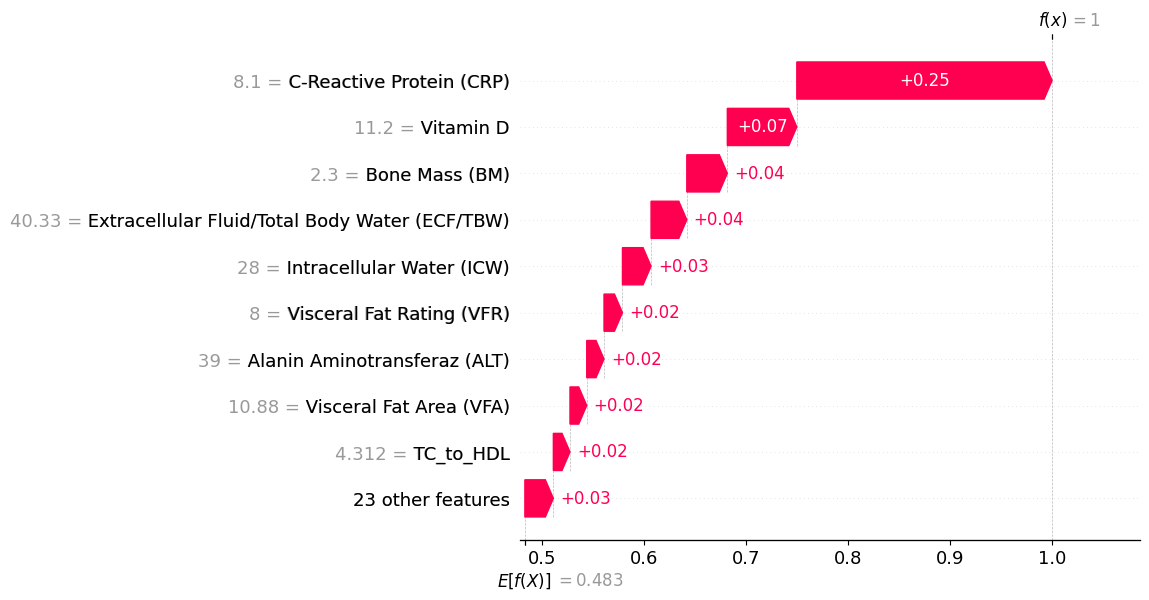

In [24]:
# Case Study (Highest Risk Sample)
probs = clf.predict_proba(X_dense)[:, 1]
idx = int(np.argmax(probs))

print(f"Case Study Patient (row position): {idx}")
print(f"Predicted Probability: {probs[idx]:.3f}")

shap.plots.waterfall(shap_values[idx])

In [25]:
# Model leaderboard (all methods + best)
cols = ["model", "roc_auc", "pr_auc", "f1", "precision", "recall", "accuracy", "brier", "best_threshold"]
summary_df = baseline_df[cols].copy()
best_idx = summary_df["pr_auc"].idxmax()
summary_df["best"] = ""
summary_df.loc[best_idx, "best"] = "<-- best"

print("\nModel Leaderboard (OOF)")
print(summary_df.to_string(index=False, float_format=lambda x: f"{x:.3f}"))


Model Leaderboard (OOF)
        model  roc_auc  pr_auc    f1  precision  recall  accuracy  brier  best_threshold     best
      xgboost    0.858   0.884 0.792      0.828   0.759     0.803  0.158           0.597 <-- best
      hist_gb    0.845   0.875 0.769      0.759   0.778     0.768  0.188           0.403         
random_forest    0.853   0.868 0.794      0.772   0.816     0.790  0.164           0.465         
     lightgbm    0.839   0.867 0.768      0.771   0.766     0.771  0.187           0.561         
      log_reg    0.869   0.864 0.818      0.796   0.842     0.815  0.143           0.397         


## Visual Validation

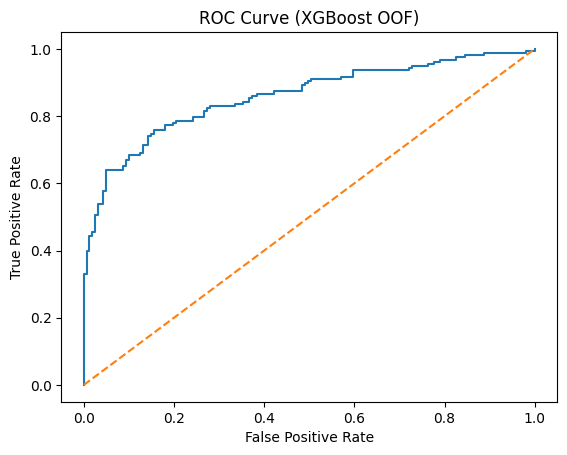

In [26]:
# ROC
fpr, tpr, _ = roc_curve(y, xgb_oof_prob)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve (XGBoost OOF)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

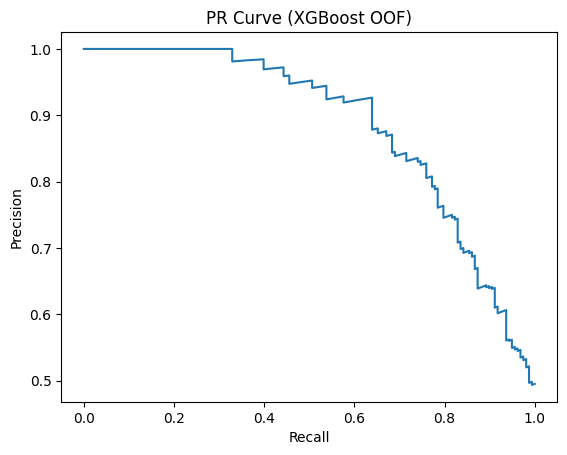

In [30]:
# PR curve
precision, recall, _ = precision_recall_curve(y, xgb_oof_prob)

plt.figure()
plt.plot(recall, precision)
plt.title("PR Curve (XGBoost OOF)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [28]:
# confusion metrics
y_pred = (xgb_oof_prob >= xgb_best_thr).astype(int)
cm = confusion_matrix(y, y_pred)
print(cm)

[[136  25]
 [ 38 120]]


In [29]:
# Risk Tier Assignment
thr = best_thr

# Define Risk Tire
risk_tier = np.where(oof_prob >= thr, "High Risk", "Low Risk")

# Dataframe
risk_df = pd.DataFrame({
    "Probability": oof_prob,
    "Risk Tier": risk_tier,
    "True Label": y_true
})

print("Risk Tier Distribution")
print(risk_df["Risk Tier"].value_counts())

# True Positive in Each Tire
print("\nObserved Gallstone Rate by Tier")
print(risk_df.groupby("Risk Tier")["True Label"].mean())

Risk Tier Distribution
Risk Tier
Low Risk     182
High Risk    137
Name: count, dtype: int64

Observed Gallstone Rate by Tier
Risk Tier
High Risk    0.854015
Low Risk     0.225275
Name: True Label, dtype: float64
